In [15]:
import matplotlib.pyplot as plt
import random
import torch
import torch.optim as optim

torch.manual_seed(0)
random.seed(0)

# ***Assignment 1.2.5 - BBVI - Algorithm 2***

BBVI algorithm II i.e. without Rao-Blackwellization

In [16]:
def generate_data(mu, tau, N):
  x = torch.linspace(-10, 10, N)
  # Insert your code here
  sigma = 1 / torch.sqrt(torch.tensor(tau))   # precision τ = 1/σ²
  torch.manual_seed(10)
  
  D = torch.normal(mu, sigma, size=(N,))

  return D


Set μ = 1, τ = 0.5 and generate a dataset with size N=100.
Plot the histogram for the generated dataset.


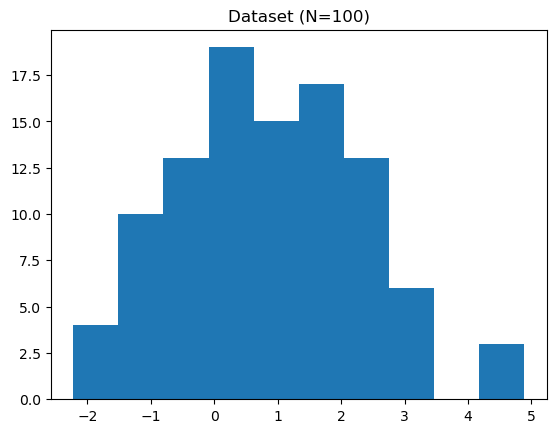

In [ ]:
mu = 1
tau = 0.5

dataset = generate_data(mu, tau, 100)

# Visulaize the datasets via histograms
plt.figure()
plt.hist(dataset)
plt.title("Dataset (N=100)")

plt.show()


In [18]:


class BlackBoxVI:
    """Black Box Variational Inference implementation."""
    
    def __init__(self, D, log_joint_distribution, variational_family_q,S=10, learning_rate=1e-3):
        """
        Black Box Variational Inference implementation without any .
            Args:
                D: dataset
                log_joint_distribution: function that computes the log joint distribution
                variational_family_q: variational family q with parameters to optimize
                S: number of samples for Monte Carlo estimation
                learning_rate: learning rate for the optimizer
        """
        self.D = D
        self.log_joint_distribution = log_joint_distribution
        self.variational_family_q = variational_family_q
        self.S = S
        self.learning_rate = learning_rate

    
    def fit(self, max_iterations = 1000):
        """Fit the variational parameters using BBVI algorithm.
        SGD optimization
        Args:
            threshold: convergence threshold
            max_iterations: maximum number of iterations
        """
        history = {
            "elbo" : [],
            "final_params" : None,
            'mu_expected': [],
            'tau_expected': [],
        }
        lr_sgd = self.learning_rate      # A small learning rate (Setting large will make it crash!)
        optimizer_sgd = optim.SGD([self.variational_family_q.parameters], lr=lr_sgd)
       
        for t in range(1,max_iterations+1):
            elbo=0
            loss=0
            optimizer_sgd.zero_grad()
            
            number_of_variational_parameters = self.variational_family_q.get_number_of_parameters()

            f = torch.zeros((number_of_variational_parameters, self.S))
            h = torch.zeros((number_of_variational_parameters, self.S))

            for s in range(self.S):
                z_s = self.variational_family_q.sample()

                #compute log(q(z[s]))
                log_q_z_s = self.variational_family_q.log_prob(z_s)
                
                # Compute log p(x, z[s])
                log_p_z_s_D = self.log_joint_distribution(self.D, z_s)
                
                # Compute the score function ∇_λ log q(z[s]; λ)
                learning_signal = (log_p_z_s_D - log_q_z_s).detach()
                
                #loss
                elbo += learning_signal

                # We need to compute ∇_λ log q(z[s]; λ) for each parameter
                grad_log_q_z_s = torch.autograd.grad(log_q_z_s, 
                                                  self.variational_family_q.parameters, 
                                                  retain_graph=True, 
                                                  create_graph=False)[0]

                 # For each variational parameter d
                for d in range(number_of_variational_parameters):
                    # Control variate computation
                    grad_d = grad_log_q_z_s[d]
                    
                    # Compute f_t and h_t for this sample
                    f[d, s] += learning_signal * grad_d
                    h[d, s] += grad_d 
                
            elbo /= self.S
                
            
            # Compute gradient with control variates for each parameter d
            final_gradient = torch.zeros(number_of_variational_parameters)
            
            for d in range(number_of_variational_parameters):
                # a_d* = Cov(f_d, h_d) / Var(h_d)
                
                f_d_mean = f[d].mean()
                h_d_mean = h[d].mean()
                
                # Covariance
                cov_f_h = ((f[d] - f_d_mean) * (h[d] - h_d_mean)).mean()
                
                # Variance of h_d
                var_h = ((h[d] - h_d_mean) ** 2).mean()
                
                # We add small epsilon to avoid division by zero
                if var_h > 1e-8:
                    a_d_star = cov_f_h / var_h
                else:
                    a_d_star = 0.0
                
                # ∇_λd L ≈ (1/S) Σ[f_i[s] - a_d* h_i[s]]
                final_gradient[d] = (f[d] - a_d_star * h[d]).mean()
            
            with torch.no_grad():
                self.variational_family_q.parameters += self.learning_rate * final_gradient
            
            #we compute the elb and we check the params every 10 iterations and at the first iteration
            if t % 10 == 0 or t == 1:
                mu_N,lambda_N, alpha_N,beta_N = self.variational_family_q.get_actual_parameters()
                history["elbo"].append((t,elbo))
                history['mu_expected'].append((t,mu_N.item()))
                history['tau_expected'].append((t,(alpha_N / beta_N).item()))
            
        history['final_params'] = self.variational_family_q.get_parameters()
        
        return history
            

**Gaussian Variational Family**

In [19]:

class NormalGammaVariationalFamily():
    
    """Variational family for Normal-NormalGamma conjugate model.
    
        Variational distribution: q(μ, τ | λ) = q(μ | τ) q(τ)
        where:
            - μ | τ ~ Normal(μ_N, (λ_N * τ)^(-1))
            - τ ~ Gamma(α_N, β_N)
        
     Parameters: λ = [μ_N, λ_N, α_N, β_N]
    """
    def __init__(self):
        """Initialize with dimension of latent variable.""" 
        mu_N = torch.randn(1).item()
        lambda_N = torch.rand(1).item() * 2 + 0.5
        alpha_N = torch.rand(1).item() * 3 + 1.0
        beta_N = torch.rand(1).item() * 3 + 0.5
        
        self.parameters = torch.tensor([
            mu_N, torch.log(torch.tensor(lambda_N)), torch.log(torch.tensor(alpha_N)), torch.log(torch.tensor(beta_N))
        ], requires_grad=True)
        
    def get_actual_parameters(self):
        mu_N = self.parameters[0]
        
        lambda_N = torch.exp(self.parameters[1])
        alpha_N = torch.exp(self.parameters[2])
        beta_N = torch.exp(self.parameters[3])
        
        return mu_N, lambda_N, alpha_N, beta_N

    def get_parameters(self):
        return self.parameters.clone()
    
    def get_number_of_parameters(self):
        return len(self.parameters)
    
    def set_parameters(self,new_params):
        self.parameters = new_params.clone()
    

    def sample(self):
        """Sample from the variational distribution.
            z[s] ~ q(μ, τ | λ)
        """
       
        mu_N, lambda_N, alpha_N, beta_N = self.get_actual_parameters()

        tau = torch.distributions.Gamma(alpha_N, beta_N).sample()
        
        
        precision = lambda_N * tau
        
        sigma_mu = 1.0 / torch.sqrt(precision)
        
        mu = torch.distributions.Normal(mu_N, sigma_mu).sample()
        
        return (mu,tau)
    
    def log_prob(self, z):
        """Compute log probability of z under the variational distribution.
            Compute log q(μ, τ | λ).
         """
        mu, tau = z
        mu_N, lambda_N, alpha_N, beta_N = self.get_actual_parameters()

        
        log_q_tau = torch.distributions.Gamma(alpha_N, beta_N).log_prob(tau)
        
        
        precision = lambda_N * tau
        
        sigma_mu = 1.0 / torch.sqrt(precision)
        
        log_q_mu_given_tau = torch.distributions.Normal(mu_N,sigma_mu).log_prob(mu)

        return log_q_tau + log_q_mu_given_tau      
        
        
    def score_function_handmade_computed(self,z):
        """
        I coomputed the score function manually ( it needs to clamp values otherwise we will have explosion of gradients )
        Compute the score function ∇_λ log q(z; λ).
          
          z = (μ^(s), τ^(s)) is a sample from the variational distribution
          λ = [μ_N, λ_N, α_N, β_N] are the variational parameters
        """
        
        mu, tau = z
        mu_N, lambda_N, alpha_N, beta_N = self.get_actual_parameters()
        eps = self.eps
        
        lambda_N_safe = lambda_N.clamp(min=eps)
        alpha_N_safe = alpha_N.clamp(min=eps)
        beta_N_safe = beta_N.clamp(min=eps)
        tau_safe = tau.clamp(min=eps)

        # Gradient log q(μ | λ) with respect to λ
        grad_mu_wrt_mu_N = (mu - mu_N) / lambda_N_safe
        grad_mu_wrt_lambda_N = ((mu - mu_N)**2 - lambda_N) / (2*lambda_N_safe**2)
        
        # Gradient log q(τ | λ) with respect to λ
        grad_tau_wrt_alpha_N = torch.log(beta_N_safe) - torch.digamma(alpha_N_safe) + torch.log(tau_safe)
        grad_tau_wrt_beta_N = (alpha_N_safe / beta_N_safe) - tau
        
            
         # === Apply chain rule for log-parametrization ===
        
        grad_log_mu_N = grad_mu_wrt_mu_N
        
        grad_log_lambda_N = lambda_N * grad_mu_wrt_lambda_N
        
        grad_log_alpha_N = alpha_N * grad_tau_wrt_alpha_N
        
        grad_log_beta_N = beta_N * grad_tau_wrt_beta_N
        
        return torch.stack([grad_log_mu_N, grad_log_lambda_N, 
                                grad_log_alpha_N, grad_log_beta_N])


**Our Model** : the initial parameters have been taken from the last assignment.

In [20]:
def log_joint_distribution(D, z):
        """Compute the log joint distribution log p(D, Z).
        Args:
            D: dataset
            Z: latent variables
        Returns:
            log p(D, Z)
        """
        # log p(D, Z) = log p(D|Z) + log p(Z)
        # Z = (mu, tau)
        
        mu, tau = z
        sigma = 1 / torch.sqrt(tau)
        
        mu_0 = 1.0
        lambda_0 = 0.1 
        a_0 = 1.0
        b_0 = 2.0  
        
        #log P(D|Z)
        log_likelihood = torch.distributions.Normal(mu, sigma).log_prob(D).sum()
        
        #log P(mu , tau) = log P(mu | tau) + log P(tau)
        
        # Log prior p(μ | τ)
        precision_mu = lambda_0 * tau
        sigma_mu = 1.0 / torch.sqrt(precision_mu)
        log_prior_mu = torch.distributions.Normal(mu_0, sigma_mu).log_prob(mu)
        
        # Log prior p(τ)
        log_prior_tau = torch.distributions.Gamma(a_0, b_0).log_prob(tau)
        
        
        return log_likelihood + log_prior_mu + log_prior_tau

## Application

In [21]:

q = NormalGammaVariationalFamily()

bbvi = BlackBoxVI(dataset,log_joint_distribution=log_joint_distribution,S = 30,variational_family_q=q,learning_rate=1e-5)
results = bbvi.fit(max_iterations=10**4)

Visualizing the results

(10000, 0.8939169645309448)

Final Results:
E_q[μ] = 0.8939 (true: 1)
E_q[τ] = 0.5269 (true: 0.5)
Data mean: 0.8901
Data precision: 0.4580


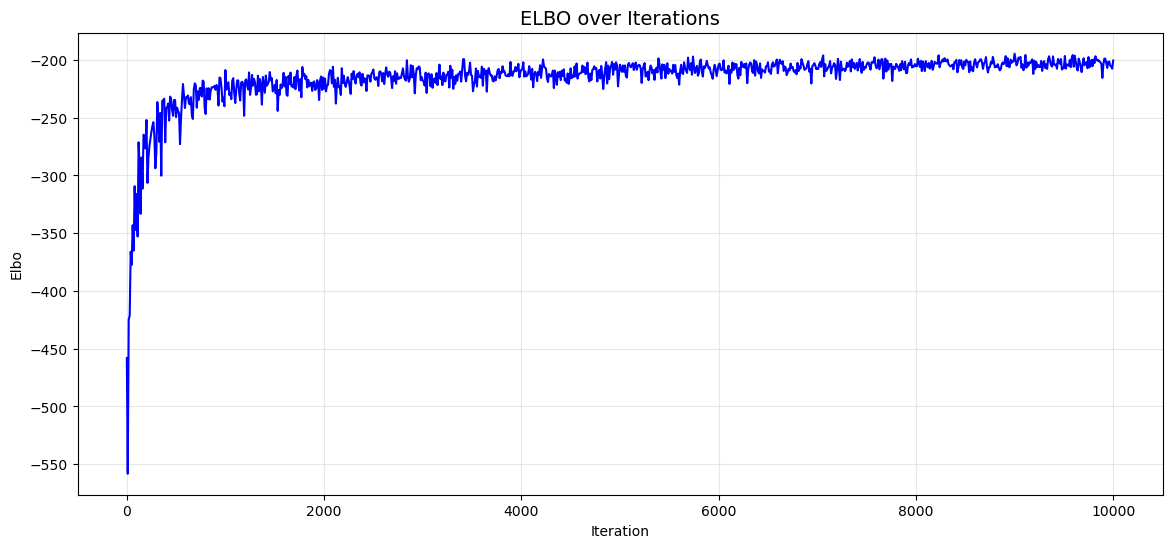

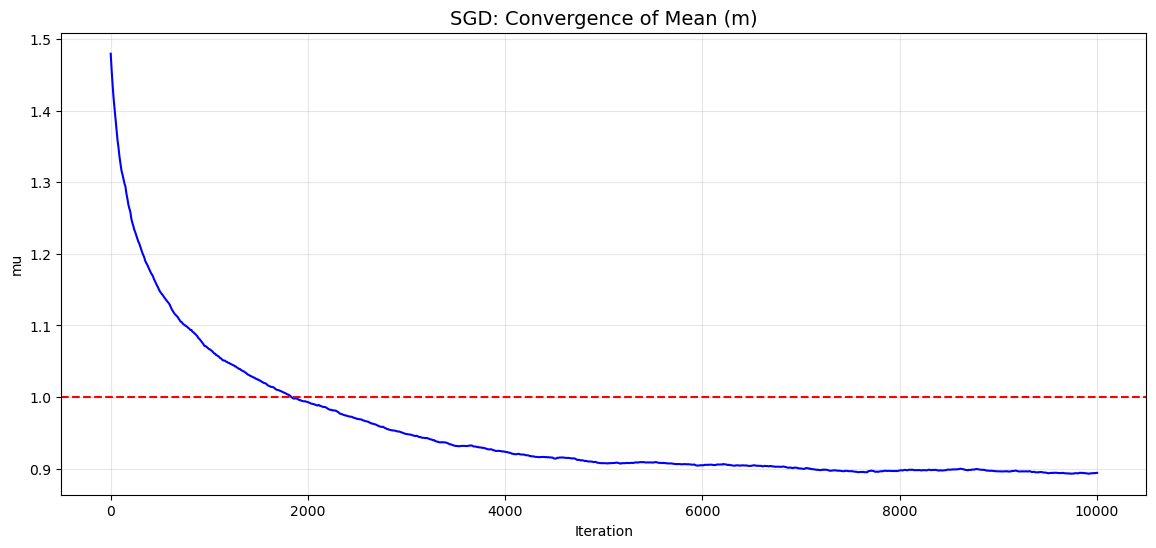

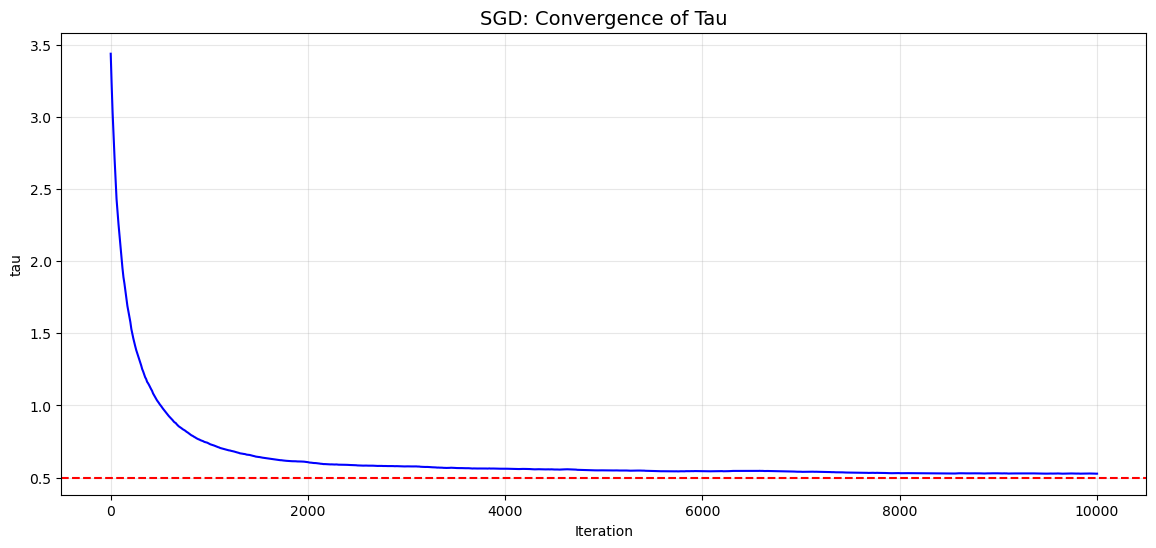

In [23]:
"""
results = {
            "elbo" : [],
            "final_params" : float,
            'mu_expected': float,
            'tau_expected': float,
        }
"""
print(results['mu_expected'][-1])
print(f"\n{'='*60}")
print(f"Final Results:")
print(f"E_q[μ] = {results['mu_expected'][-1][1]:.4f} (true: {mu})")
print(f"E_q[τ] = {results['tau_expected'][-1][1]:.4f} (true: {tau})")
print(f"Data mean: {dataset.mean():.4f}")
print(f"Data precision: {1.0/dataset.var():.4f}")
print(f"{'='*60}")

### Plot of the ELBO
plt.figure(figsize=(14, 6))
iterations, elbos = zip(*results["elbo"])
plt.plot(iterations,elbos,'b-')
plt.xlabel("Iteration")
plt.ylabel("Elbo")
plt.title('ELBO over Iterations', fontsize=14)
plt.grid(alpha=0.3)


### Plot for m
plt.figure(figsize=(14, 6))
iterations, mu_expected = zip(*results["mu_expected"])
plt.plot(iterations,mu_expected,'b-')
plt.axhline(mu, color='r', linestyle='--', label="real value")
plt.xlabel("Iteration")
plt.ylabel("mu")
plt.title('SGD: Convergence of Mean (m)', fontsize=14)
plt.grid(alpha=0.3)




### Plot for tau
plt.figure(figsize=(14, 6))
iterations, tau_expected = zip(*results["tau_expected"])
plt.plot(iterations,tau_expected,'b-')
plt.axhline(tau, color='r', linestyle='--', label="real value")
plt.xlabel("Iteration")
plt.ylabel("tau")
plt.title('SGD: Convergence of Tau', fontsize=14)
plt.grid(alpha=0.3)